# **IndabaX South Sudan 2025 — Hackathon (Intermediate Track)**

### **Weather Condition Classification using Modern CNN Architecture**

This notebook implements a weather classification system using transfer learning with MobileNetV2 and custom CNN layers to achieve high accuracy on the multi-class weather dataset.

### **Dreamers Team Members**
- Madol Abarahm Kuol - Team Leader 
- John Akech  
- Jok James Dut  
- Geu Aguto Garang  
- Kuir Juach Kuir

## **Import Essential Libraries**

In [4]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

## **Loading The dataset**

In [90]:
# Configuration
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Data paths
TRAIN_DIR = '/Users/geuaguto/Desktop/Hackathon SSD/weather_dataset'
TEST_DIR = '/Users/geuaguto/Desktop/Hackathon SSD/test'

# Class names
CLASS_NAMES = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
NUM_CLASSES = len(CLASS_NAMES)

# Print the number of classes
print(f"Training directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Classes: {CLASS_NAMES}")
print(f"Number of classes: {NUM_CLASSES}")

Training directory: /Users/geuaguto/Desktop/Hackathon SSD/weather_dataset
Test directory: /Users/geuaguto/Desktop/Hackathon SSD/test
Classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Number of classes: 4


## **Display the Dataset**

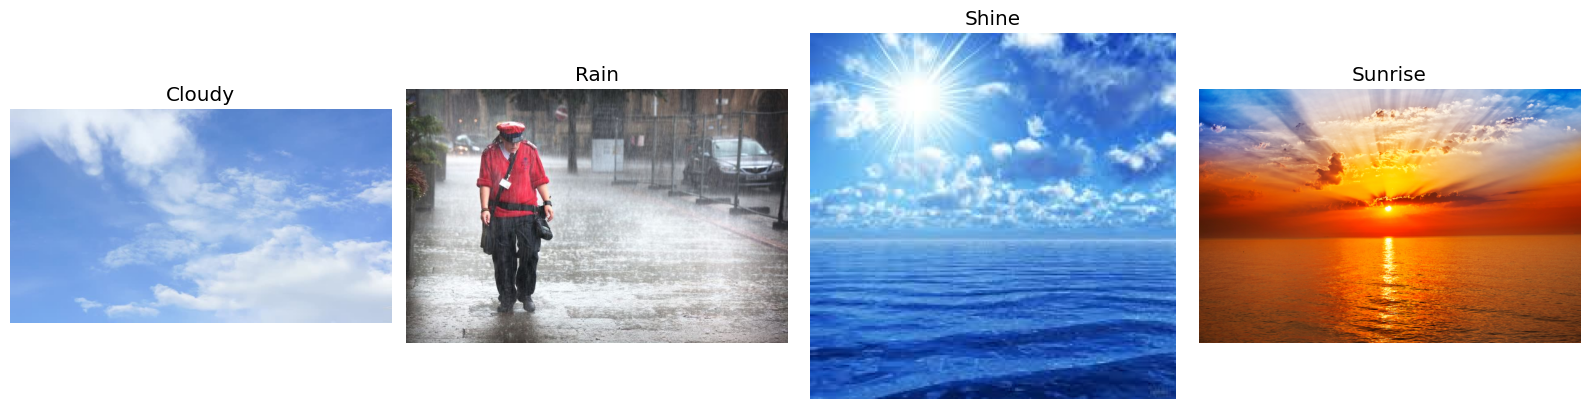

In [101]:
# Display one image per class at their actual size
def display_dataset():
    train_dir = TRAIN_DIR 
    
    # Display one image per class
    num_classes = len(CLASS_NAMES)
    plt.figure(figsize=(4 * num_classes, 4))
    
    for i, cls in enumerate(CLASS_NAMES):
        cls_path = os.path.join(train_dir, cls)
        if os.path.exists(cls_path):
            image_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                img_path = os.path.join(cls_path, image_files[0])
                try:
                    img = plt.imread(img_path)
                    plt.subplot(1, num_classes, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')
                except Exception as e:
                    print(f"Error loading image from {cls}: {e}")
            else:
                print(f"No image files found in class '{cls}'")
        else:
            print(f"Class directory does not exist: {cls_path}")

    plt.tight_layout()
    plt.show()

# Run the function
display_dataset()

## **Data Preprocessing**

### **1. Resizing the images for training**

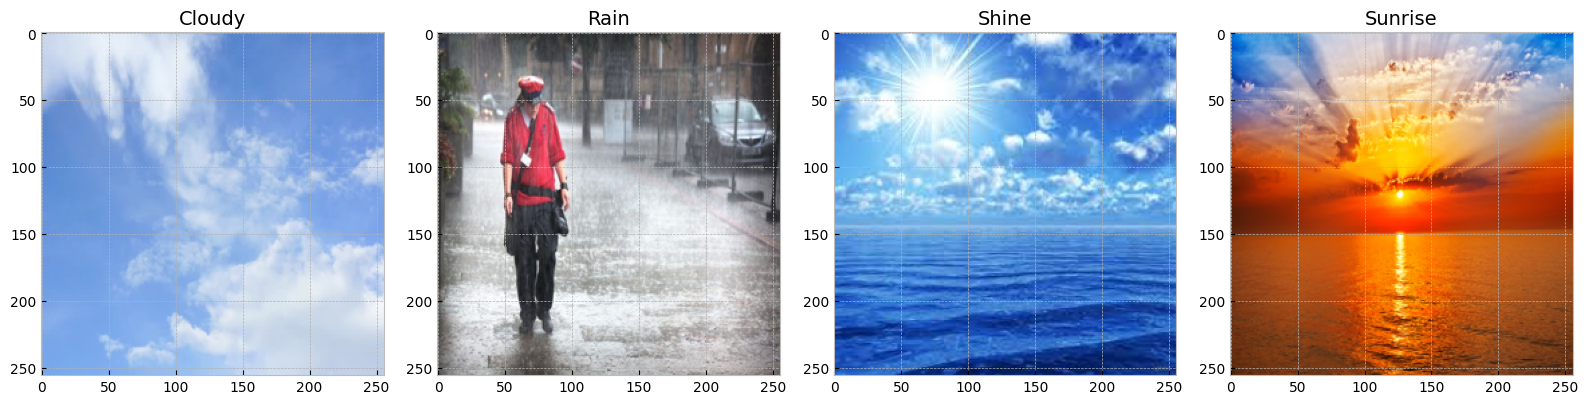

In [102]:
def display_resized_sample_images_with_axes(data_path, class_names, img_size=(256, 256)):
    """Display one resized sample image per class with visible x and y axes."""
    num_classes = len(class_names)
    plt.figure(figsize=(4 * num_classes, 4))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.exists(class_path):
            print(f"Class folder not found: {class_path}")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not image_files:
            print(f"No images found in: {class_path}")
            continue

        # Load and resize the first image
        img_path = os.path.join(class_path, image_files[0])
        img = Image.open(img_path).convert('RGB')
        img = img.resize(img_size)

        plt.subplot(1, num_classes, i + 1)
        plt.imshow(img)
        plt.title(class_name, fontsize=14)
        plt.axis('on') 
        plt.xticks(ticks=range(0, img_size[0]+1, 50))
        plt.yticks(ticks=range(0, img_size[1]+1, 50))

    plt.tight_layout()
    plt.show()

# Call the function
display_resized_sample_images_with_axes(TRAIN_DIR, CLASS_NAMES)

### **2. Check the number of images per class**

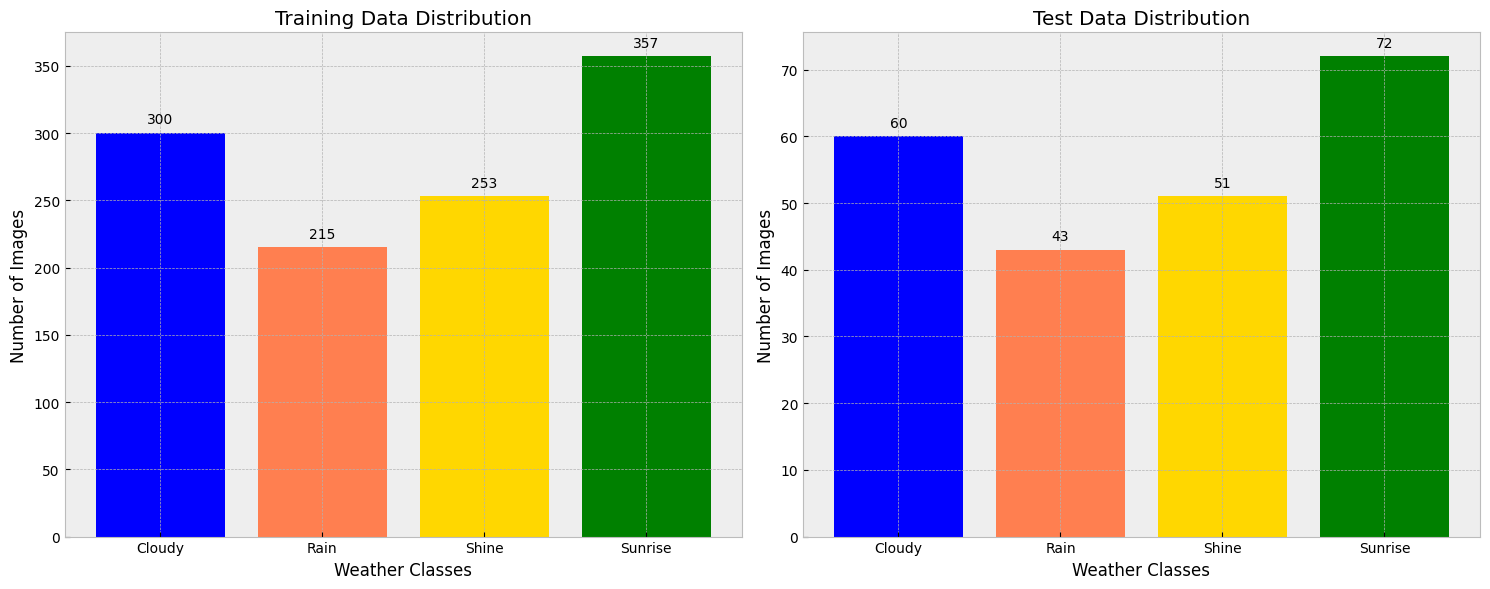

Training Data:
Cloudy: 300 images
Rain: 215 images
Shine: 253 images
Sunrise: 357 images

Test Data:
Cloudy: 60 images
Rain: 43 images
Shine: 51 images
Sunrise: 72 images


In [105]:
# Count images in each class for training data
train_counts = {}
for class_name in CLASS_NAMES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    train_counts[class_name] = len(os.listdir(class_path))

# Count images in each class for test data
test_counts = {}
for class_name in CLASS_NAMES:
    class_path = os.path.join(TEST_DIR, class_name)
    test_counts[class_name] = len(os.listdir(class_path))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training data distribution
ax1.bar(train_counts.keys(), train_counts.values(), color=['blue', 'coral', 'gold', 'green'])
ax1.set_title('Training Data Distribution')
ax1.set_ylabel('Number of Images')
ax1.set_xlabel('Weather Classes')
for i, v in enumerate(train_counts.values()):
    ax1.text(i, v + 5, str(v), ha='center', va='bottom')

# Test data distribution
ax2.bar(test_counts.keys(), test_counts.values(), color=['blue', 'coral', 'gold', 'green'])
ax2.set_title('Test Data Distribution')
ax2.set_ylabel('Number of Images')
ax2.set_xlabel('Weather Classes')
for i, v in enumerate(test_counts.values()):
    ax2.text(i, v + 1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Training Data:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nTest Data:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")

## **Data Augmentation**

In [106]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 226 images belonging to 4 classes.
Training samples: 901
Validation samples: 224
Test samples: 226
Class indices: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}


## **Model Architecture - Transfer Learning with MobileNetV2**

In [11]:
def create_model():
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

# Create model
model, base_model = create_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created successfully!")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

Model created successfully!
Total parameters: 3,053,380
Trainable parameters: 791,812


## **Training Callbacks**

In [12]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [reduce_lr]

### **Phase 1: Train Classification Head**

In [13]:
history_phase1 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5655 - loss: 1.2221 - val_accuracy: 0.8482 - val_loss: 0.4228 - learning_rate: 0.0010
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8889 - loss: 0.3065 - val_accuracy: 0.8750 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8795 - loss: 0.3729 - val_accuracy: 0.9018 - val_loss: 0.2646 - learning_rate: 0.0010
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9081 - loss: 0.2506 - val_accuracy: 0.9152 - val_loss: 0.2257 - learning_rate: 0.0010
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9143 - loss: 0.2523 - val_accuracy: 0.8839 - val_loss: 0.2556 - learning_rate: 0.0010
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9199 - loss: 0.2104 - val_accuracy: 0.9018 - val_loss: 0.2144 - learning_rate: 0.0010
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9157 - loss: 0.2768 - val_accuracy: 

### **Phase 2: Fine-tuning**

In [14]:
print("Phase 2: Fine-tuning the entire model...")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters after unfreezing: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Continue training with fine-tuning
history_phase2 = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2 training completed!")

Phase 2: Fine-tuning the entire model...
Trainable parameters after unfreezing: 3,015,684
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.8048 - loss: 0.7691 - val_accuracy: 0.6562 - val_loss: 1.7002 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.9061 - loss: 0.3383 - val_accuracy: 0.8214 - val_loss: 0.9057 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9238 - loss: 0.2205 - val_accuracy: 0.8348 - val_loss: 0.6920 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9418 - loss: 0.1661 - val_accuracy: 0.8527 - val_loss: 0.7790 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9468 - loss: 0.1794 - val_accuracy: 0.5938 - val_loss: 3.0982 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.9373 - loss: 0.1921 - val_accuracy: 0.6607 - val_loss: 2.1467 - learni

## **Visualization**

### **1. Models Accuracy and Loss Curve**

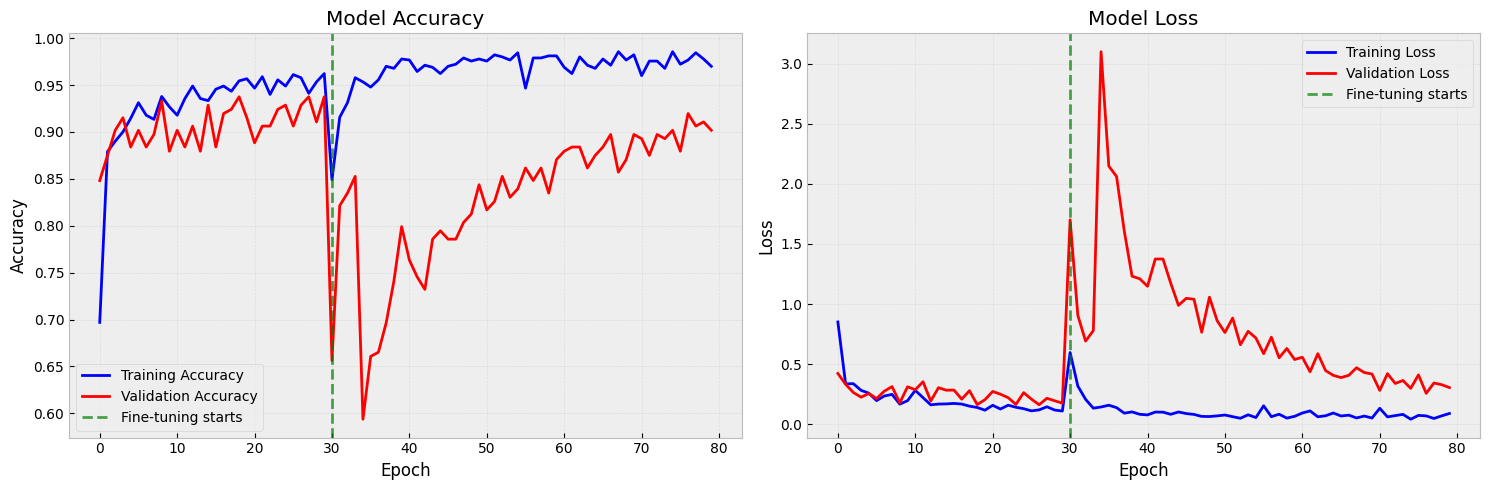

Final Training Accuracy: 0.9700
Final Validation Accuracy: 0.9018


In [107]:
# Combine training histories
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

combined_history = combine_histories(history_phase1, history_phase2)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(combined_history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(combined_history['val_accuracy'], label='Validation Accuracy', color='red')
ax1.axvline(x=len(history_phase1.history['accuracy']), color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(combined_history['loss'], label='Training Loss', color='blue')
ax2.plot(combined_history['val_loss'], label='Validation Loss', color='red')
ax2.axvline(x=len(history_phase1.history['loss']), color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = combined_history['accuracy'][-1]
final_val_acc = combined_history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

### **2. Confusion Matrix**

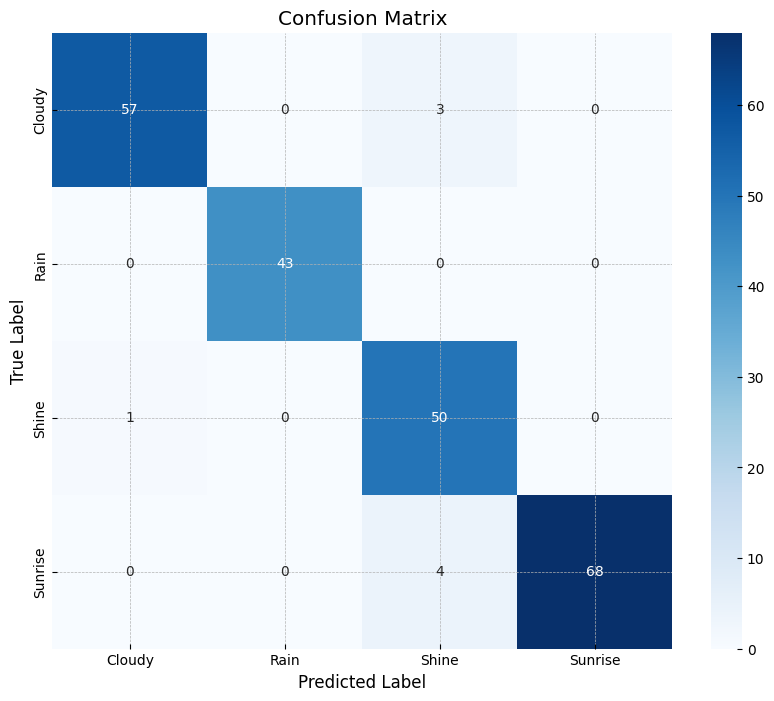


Per-class Accuracy:
Cloudy: 0.9500 (95.00%)
Rain: 1.0000 (100.00%)
Shine: 0.9804 (98.04%)
Sunrise: 0.9444 (94.44%)


In [108]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:.2f}%)")

## **Model Evaluation on Test Set**

In [109]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

Evaluating model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - accuracy: 0.9582 - loss: 0.0919

Test Accuracy: 0.9646 (96.46%)
Test Loss: 0.0881
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 667ms/step

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.98      0.95      0.97        60
        Rain       1.00      1.00      1.00        43
       Shine       0.88      0.98      0.93        51
     Sunrise       1.00      0.94      0.97        72

    accuracy                           0.96       226
   macro avg       0.96      0.97      0.97       226
weighted avg       0.97      0.96      0.97       226



## **Sample Predictions**

Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


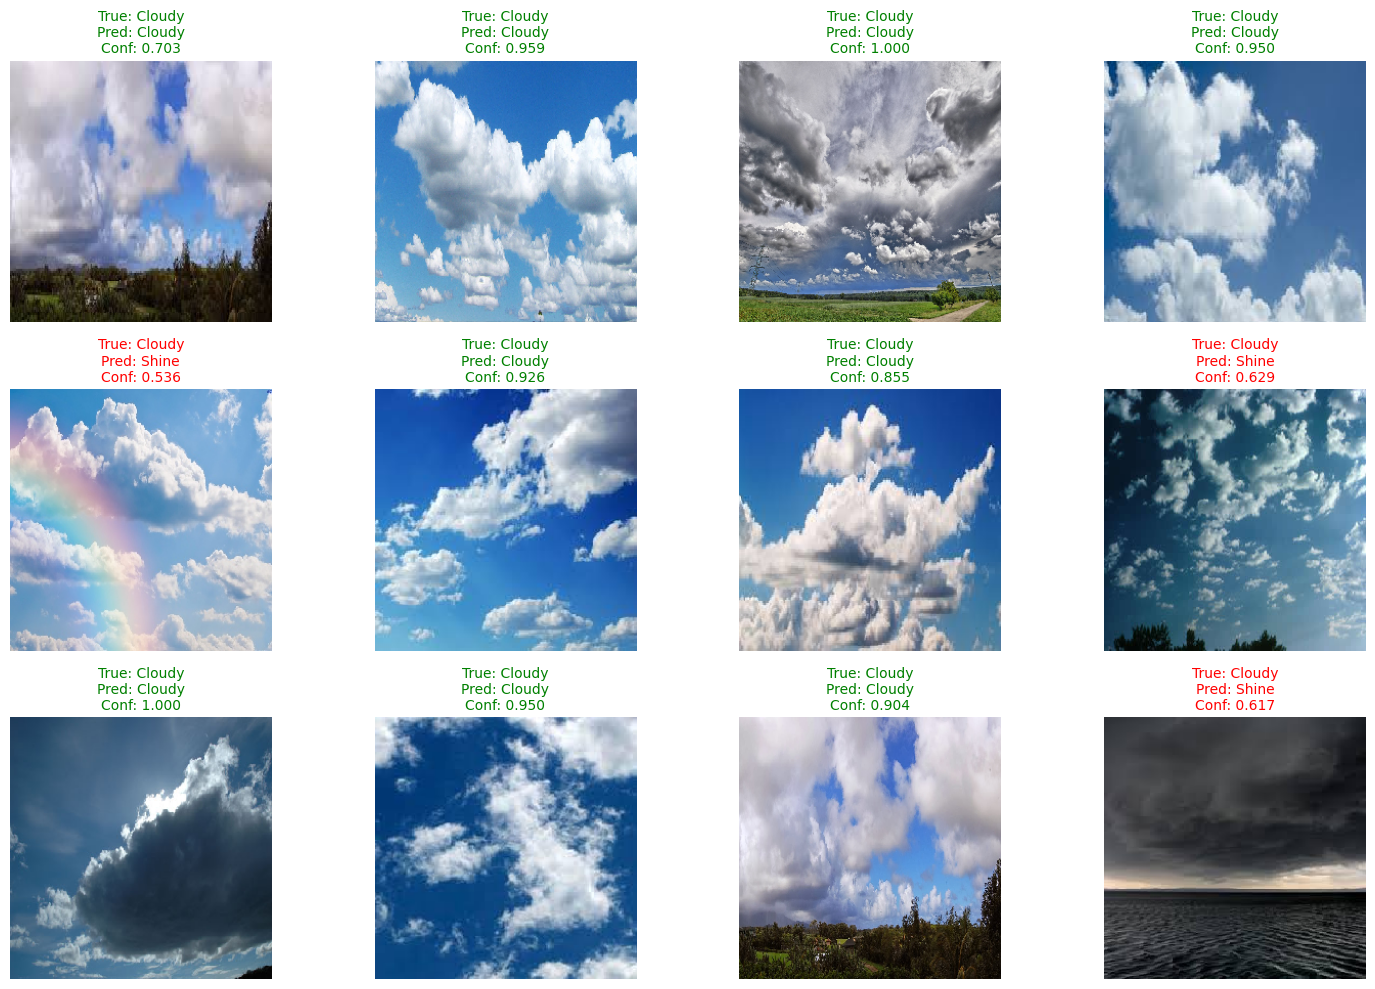

In [110]:
# Function to display sample predictions
def plot_sample_predictions(generator, model, num_samples=12):
    generator.reset()
    batch_images, batch_labels = next(generator)

    predictions = model.predict(batch_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_labels, axis=1)

    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(batch_images[i])

        true_label = class_names[true_classes[i]]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]]

        color = 'green' if true_classes[i] == predicted_classes[i] else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample predictions
print("Sample Predictions:")
plot_sample_predictions(test_generator, model)

## **Model Summary and Results**

In [111]:
def print_separator(char="-", length=60):
    print(char * length)

def print_metric(label, value, is_percentage=False):
    if is_percentage:
        print(f"{label:<30}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"{label:<30}: {value}")

# Print model summary
print("WEATHER CLASSIFICATION MODEL RESULTS".center(60))
print_separator()
print_metric("Architecture", "Transfer Learning with MobileNetV2")
print_metric("Input Size", f"{IMG_SIZE}x{IMG_SIZE}x3")
print_metric("Number of Classes", NUM_CLASSES)
print_metric("Total Parameters", f"{model.count_params():,}")
print_metric("Training Samples", train_generator.samples)
print_metric("Validation Samples", validation_generator.samples)
print_metric("Test Samples", test_generator.samples)

# Print performance metrics
print_separator()
print("PERFORMANCE METRICS:".center(60))
print_metric("Final Training Accuracy", final_train_acc, is_percentage=True)
print_metric("Final Validation Accuracy", final_val_acc, is_percentage=True)
print_metric("Test Accuracy", test_accuracy, is_percentage=True)
print_metric("Test Loss", test_loss)
print_separator()


            WEATHER CLASSIFICATION MODEL RESULTS            
------------------------------------------------------------
Architecture                  : Transfer Learning with MobileNetV2
Input Size                    : 256x256x3
Number of Classes             : 4
Total Parameters              : 3,053,380
Training Samples              : 901
Validation Samples            : 224
Test Samples                  : 226
------------------------------------------------------------
                    PERFORMANCE METRICS:                    
Final Training Accuracy       : 0.9700 (97.00%)
Final Validation Accuracy     : 0.9018 (90.18%)
Test Accuracy                 : 0.9646 (96.46%)
Test Loss                     : 0.08805572986602783
------------------------------------------------------------


In [112]:
# Binarize the test labels
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
y_pred_bin = y_pred_proba  

# Compute AUC
roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
print(f"Macro-Averaged ROC AUC: {roc_auc:.4f}")


Macro-Averaged ROC AUC: 0.9988


## **ROC Curves**

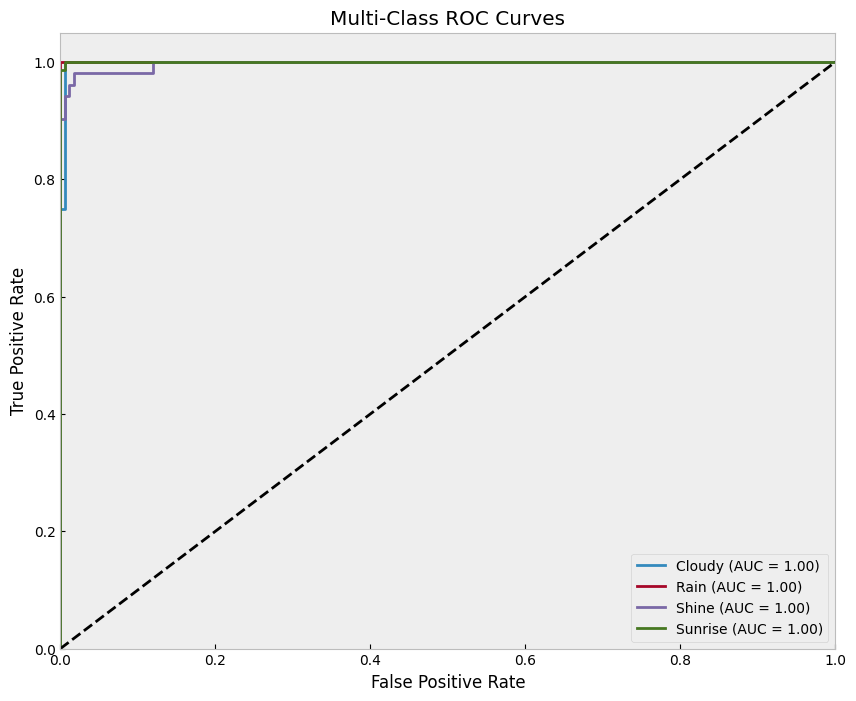

In [113]:
# Get class names
class_names = list(test_generator.class_indices.keys())

# Plot setup
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc_i:.2f})')

# Diagonal baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [114]:
print("Sample true labels:", y_true[:10])
print("Sample one-hot labels:\n", y_true_bin[:10])
print("Sample predicted probabilities:\n", y_pred_proba[:10])
print("Sum of predicted probabilities per sample:\n", np.sum(y_pred_proba, axis=1)[:10])
print("Test generator shuffle:", test_generator.shuffle)


Sample true labels: [0 0 0 0 0 0 0 0 0 0]
Sample one-hot labels:
 [[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Sample predicted probabilities:
 [[7.0283991e-01 7.0032300e-08 2.9716000e-01 8.8842739e-08]
 [9.5907158e-01 1.1544572e-06 4.0923983e-02 3.3579788e-06]
 [9.9977088e-01 1.4164956e-08 2.2890809e-04 8.3267715e-08]
 [9.5026374e-01 2.0294041e-05 4.9700178e-02 1.5795598e-05]
 [4.6364641e-01 5.1208528e-05 5.3600150e-01 3.0088858e-04]
 [9.2610842e-01 1.8284975e-06 7.3884256e-02 5.4183879e-06]
 [8.5547698e-01 7.5288322e-06 1.4450221e-01 1.3211848e-05]
 [2.9779330e-01 4.5897372e-02 6.2927425e-01 2.7035093e-02]
 [9.9989098e-01 1.0972229e-08 1.0383932e-04 5.1561374e-06]
 [9.4965690e-01 1.6808637e-05 5.0314508e-02 1.1899211e-05]]
Sum of predicted probabilities per sample:
 [1.0000001  1.         0.9999998  1.         1.         0.99999994
 0.99999994 1.         1.         1.0000001 ]
Test generator shuffle: False


### **Save the Trained Model**

In [115]:
#Save the model
model.save('dreamers_weather_model.h5')

## **Final Prediction Using Test Dataset**

In [116]:
# Set the image name to predict
image_name  = 'rain10.jpg'  # Change this to any image name

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


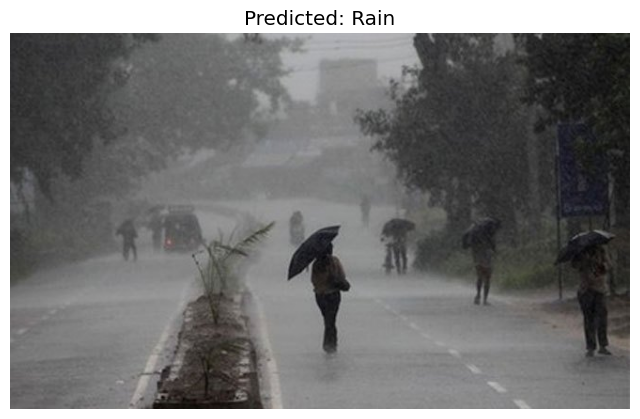

Prediction: Rain


In [117]:
# Load the saved model
loaded_model = tf.keras.models.load_model('/Users/geuaguto/Desktop/Hackathon SSD/ًdreamers_Weather Model.h5')

# Define classes
classes = CLASS_NAMES

# Find image by name across all test subdirectories
image_path = None
for class_folder in classes:
    search_path = f'test/{class_folder}/{image_name}'
    if os.path.exists(search_path):
        image_path = search_path
        break

if image_path is None:
    print(f"Image '{image_name}' not found in test directory")
else:
    # Make prediction
    image = Image.open(image_path)
    img = image.resize((256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.0

    predictions = loaded_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = classes[tf.argmax(score)]

    # Display image with prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

    print(f"Prediction: {predicted_class}")

## **Save Submission File**

In [118]:
# Load model
model = tf.keras.models.load_model('ًdreamers_Weather Model.h5')

# Predict
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_indices = np.argmax(predictions, axis=1)

# Map indices to class names (e.g., 0 -> 'Cloudy')
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
predicted_labels = [index_to_class[idx] for idx in predicted_indices]

# Create submission DataFrame with id starting from 1
submission_df = pd.DataFrame({
    'id': range(1, len(predicted_labels) + 1),
    'label': predicted_labels
})

# Save the file
submission_df.to_csv('submission.csv', index=False)
print("Correctly formatted submission file created: submission.csv")


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 828ms/step
Correctly formatted submission file created: submission.csv


## **THE END!!**

#### **By Dreamers Team (African Leadership Univeristy Final Year Students - Software Engineering, Machine Learning Specialzation 2025)**